In [2]:
pip install catboost

     |████████████████████████████████| 76.3 MB 1.3 MB/s 


In [3]:
pip install optuna

     |████████████████████████████████| 308 kB 21.7 MB/s 
     |████████████████████████████████| 209 kB 50.0 MB/s 
     |████████████████████████████████| 80 kB 6.9 MB/s 
     |████████████████████████████████| 75 kB 3.8 MB/s 
     |████████████████████████████████| 49 kB 4.8 MB/s 
     |████████████████████████████████| 112 kB 62.9 MB/s 
     |████████████████████████████████| 149 kB 52.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=9f1dddac2b0ffd3fc76bda46d790fa692e4ab462955ebf1f925e8e06b17c0f27
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [4]:
pip install shap

     |████████████████████████████████| 564 kB 27.7 MB/s 


In [5]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

import catboost as cb
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)

import shap

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_auc_score, f1_score, fbeta_score, roc_curve, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from yellowbrick.classifier import ROCAUC
from yellowbrick.contrib.wrapper import wrap


In [6]:
# seed everything

my_seed = 42

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(my_seed)

In [7]:

file = 'student-grades.csv'

In [11]:
df = pd.read_csv(file)

df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


In [12]:
df.shape

(395, 33)

In [13]:
df.isnull().values.any()

False

In [14]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [15]:
df.describe(include=[object])

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,349,208,307,281,354,141,217,145,273,344,242,214,201,314,375,329,263


# Feature Engineering

In [16]:
# create pass and fail column

df['pass'] = np.where(df['G3'] >= 10, 'pass', 'fail')

In [17]:
# create letter grade column

df.loc[df['G3'] < 10, 'Grade'] = 'F'
df.loc[(df['G3'] >= 10) & (df['G3'] <= 11), 'Grade'] = 'D'
df.loc[(df['G3'] >= 12) & (df['G3'] <= 13), 'Grade'] = 'C'
df.loc[(df['G3'] >= 14) & (df['G3'] <= 15), 'Grade'] = 'B'
df.loc[df['G3'] >= 16, 'Grade'] = 'A'

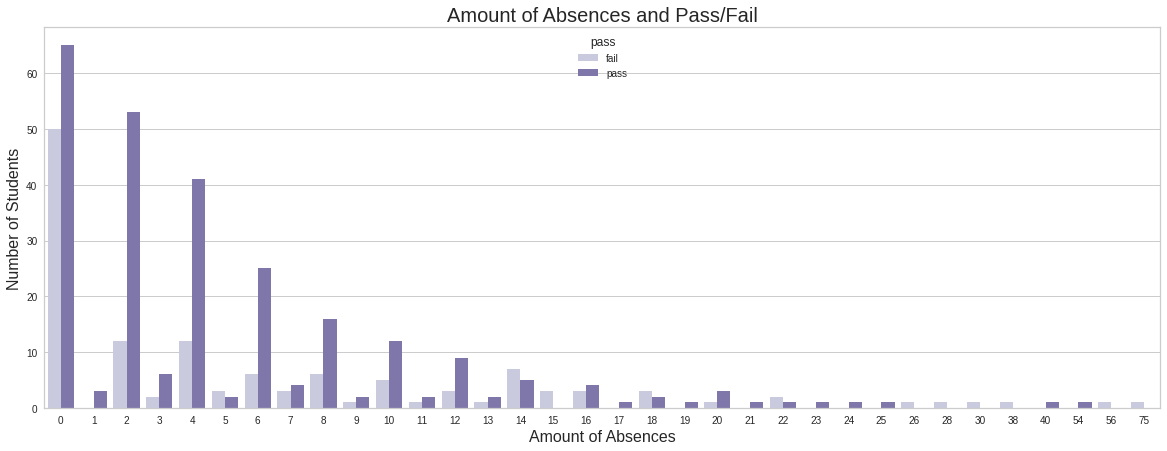

In [18]:
# plot absences vs pass/fail

fig = plt.figure(figsize=(20, 7))

study = sns.countplot(data=df, x="absences", hue="pass", palette='Purples')

plt.title('Amount of Absences and Pass/Fail', fontsize=20)
plt.xlabel('Amount of Absences', fontsize=16)
plt.ylabel('Number of Students', fontsize=16)

plt.show()

In [19]:
# binning the days

df['absences'] = df['absences'].replace([1, 3, 5, 7, 9, 11 ,13, 15, 17, 19, 21, 23, 25],
                       [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26])

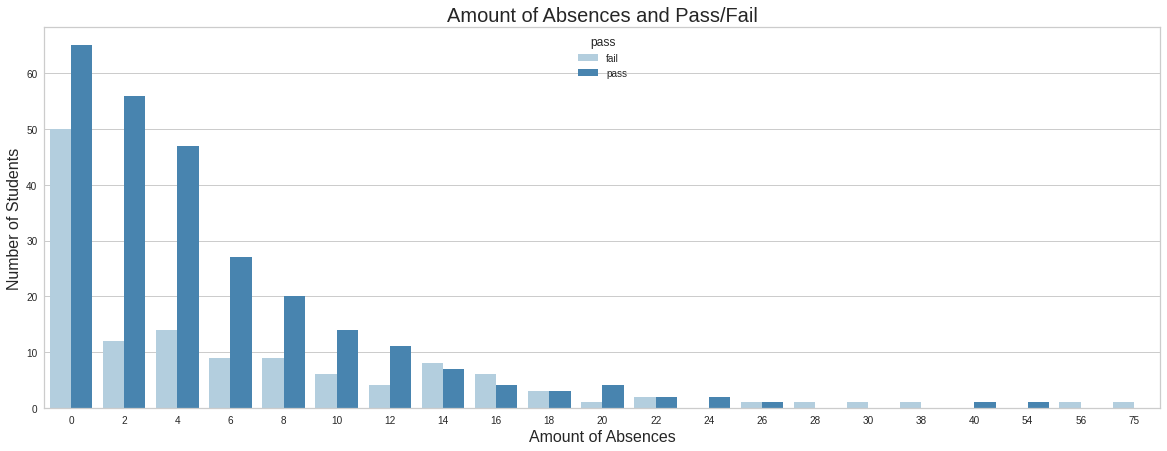

In [20]:
# plot absences vs pass/fail

fig = plt.figure(figsize=(20, 7))

study = sns.countplot(data=df, x="absences", hue="pass", palette='Blues')

plt.title('Amount of Absences and Pass/Fail', fontsize=20)
plt.xlabel('Amount of Absences', fontsize=16)
plt.ylabel('Number of Students', fontsize=16)

plt.show()

In [21]:
# manually encoding pass column

fmap = {'pass':1, 'fail':0}

# apply filter to pass column

df['pass'] = df['pass'].map(fmap)

In [22]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'pass', 'Grade'],
      dtype='object')

In [23]:
categorical_features_indices = [0, 1, 3, 4, 5, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20 ,21, 22]

# 1) Regression Modeling (Number Grade)

## A) Modeling After the Second Trimester (G1, G2) for Final Grade (G3)

In [21]:
train_df , test_df = train_test_split(df, test_size=0.2, random_state=my_seed, stratify=df['Grade'])

In [22]:
features = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
           'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
           'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
           'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
           'Walc', 'health', 'absences', 'G1', 'G2']
target = ['G3']

In [23]:
train_features = train_df[features]
train_target = train_df[target]

test_features = test_df[features]
test_target = test_df[target]

In [26]:
def objective(trial):

    params = {
                     "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
                     'od_wait': trial.suggest_int('od_wait', 10, 50, step=1),
                     "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.99),
                     "random_strength": trial.suggest_int("random_strength", 1, 10, step=1),
                     "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 50.0),
                     "max_depth": trial.suggest_int("max_depth", 2, 10, step=1),
                     "n_estimators": trial.suggest_int("n_estimators", 100, 3000, step=1),
                     'learning_rate': trial.suggest_loguniform("learning_rate", 0.005, 0.1),
                     "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 60),
                    "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
                    "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
                    "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 10),
                    }

    # Conditional Hyper-Parameters
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)
    elif params["bootstrap_type"] == "MVS":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=my_seed)

    cv_scores = []

    for train_index, test_index in skf.split(train_features,train_target):

        train_x, valid_x = train_features.iloc[train_index], train_features.iloc[test_index]
        train_y, valid_y = train_target.iloc[train_index], train_target.iloc[test_index]  

        train_pool = cb.Pool(train_x, train_y, cat_features=categorical_features_indices)
        valid_pool = cb.Pool(valid_x, valid_y, cat_features=categorical_features_indices)

        cb_reg_model = cb.CatBoostRegressor(**params, random_state=my_seed)

        cb_reg_optuna = cb_reg_model.fit(train_pool, eval_set=valid_pool, verbose=False, 
                                         early_stopping_rounds=100, use_best_model=True)

        preds = cb_reg_optuna.predict(valid_x)

        MAE = mean_absolute_error(valid_y, preds)

        cv_scores.append(MAE)

    cv_avg_score = np.mean(cv_scores)    

    print('Avg MAE score of CV CatBoost Regression=', cv_avg_score)

    return cv_avg_score

In [27]:
study = optuna.create_study(direction="minimize", sampler = TPESampler(seed=my_seed), study_name="Trimester 2 Regression")
study.optimize(objective, n_trials=300, n_jobs=-1)

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.3895571323172813


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2226697419946735


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2519751970152575


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.580138142227471


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2263767469775098


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.9201439785696137


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.108671190658582


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.4791950911761016


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2049821726483252


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 2.0311834316183144


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1068261735967997


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.121560998026615


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2123115991075462


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1239709919132195


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2150024742449124


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.3068795159876436


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0981934483414282


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1513116917348996


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.288771669837039


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.8589915847941794


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.3295502848636336


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1386420453918775


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1108834918195527


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1432728764970315


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1072079952640383


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1495634233693175


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.171413101636186


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.607750175092867


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5031163629683788


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.3580854956980168


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2542760822022068


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1102948968203286


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1157424988827978


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1824142907324382


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2306089352477723


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0856235044694702


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2438739258500404
Avg MAE score of CV CatBoost Regression= 1.092810533973473


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.161560668701941
Avg MAE score of CV CatBoost Regression= 1.0991216169981919


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1314456291056358


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1670516568797427


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1012965011218465


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1194923035720468
Avg MAE score of CV CatBoost Regression= 1.1265042809295494


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.109725918737253
Avg MAE score of CV CatBoost Regression= 1.1507908520319643


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2497434537384735


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.235887145533186


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1212958251699823


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.35891279044363


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.124357937386168


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0999402811334538


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1482963570395899


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.115550249512361


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.4653416811857245


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2081063661805966


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.3639401147902424


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2308322782762315


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1134996798558636


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1176511379577794


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0884893204047128


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0970529954918053


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0908261541431095


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0758261370163356


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0822513284405844


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1166909015819877


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1323651408784998


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1174122981234944


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.347722994806285


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0796155577908846


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0865108731303619


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0907291602367535


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0801254162723528


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.256696881122764


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1186626571127973


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0913787124220988


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1178409598390069


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 2.0187124791035798


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.138432973272669


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.092994422006024


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.083099058959944


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.084413176741885


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.071494350326855


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0723041213817717


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0782895457826096


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1000141141679523


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1094832832080883


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.189099329185338


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1989616375972365


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1378262826285621


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0665588299351225


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1519564793981543


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.079703312337441


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0803070947954965


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0735307707249173


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1062063587671758


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.072981734752123


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1036424302475225


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0763018305653422


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.092014756474011


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0925480401718608


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1130189138907336


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0890271018289341


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1167157627107445


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0912767000202224
Avg MAE score of CV CatBoost Regression= 1.0849335235827249


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.1330397770792484


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1883613873893077


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.090605385585317


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.083985924077815


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0665945280824767


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.081594007388867


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.327522960583962


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.141755004756772


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.072739116052886


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0998483192338313
Avg MAE score of CV CatBoost Regression= 1.0767993626756795


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0741155360381243


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.090761275209956


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0886605660908253


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0663534625628934


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0681647575052267


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0665607483610668


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0817846175706767


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0717432398841982


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0745377602077746


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.3744727549384987


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2804590793382318


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0850232974749132


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.07403351999011


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.4903879527881987


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.146974788226117


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0738863374246728


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.103981216294083


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0808240707673988


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0724765625686807


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0738541424244372


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0734719066121756


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.078163236722955


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0783090314898116


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1091791972401048


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0701687289239343


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2075565279741713


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.130130005877135


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1033418650103577
Avg MAE score of CV CatBoost Regression= 1.0958464636721694


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.1160774088084033


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1207302617979886


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0699241254299832


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1727504854153539


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.089971919399177


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1266950879216295


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.080364122745691


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.10142934579552


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0926184928847031


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0703343027524284


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.075616104590208


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0761737478215019


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2306968594918453


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1990021598253642


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0922873471283086


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0648372594372866


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0948591700191748


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0824505697086548


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0660911060733518


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0679337585039266


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.076309639787402


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0758061354579613


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0844699826565503


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0731272700679033
Avg MAE score of CV CatBoost Regression= 1.0754693572994107


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0634477846068642


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0772471502565053


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0705962868598078


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0978513392893814


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0790006260927463


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0682756355289251


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.245673152312126


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.101746575895353
Avg MAE score of CV CatBoost Regression= 1.0763815261269323


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0838813968270231


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0762475584152618


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0760847677346774


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0694791866473479


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0737290740369885


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0872399466799991


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0941644625723306


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0917573618864274


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0664283270135484


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0822441412893093


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0674912992760133


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0717715925811984


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0818268905494186


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0609366703000953


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0770081760108592


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.070821414803778


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0987576531518997


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.067613438013634


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0506078876999125


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0872980666776537


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.076666747284916


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0869138991374
Avg MAE score of CV CatBoost Regression= 1.075681207824339


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.073449142215194


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0802902704606514


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.071929399637955


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0822981024556715


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1041951712229132


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1590918831800359


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.138156979094599


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0656712004517246


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1032343217267042


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0658546008099565


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0717718057789045


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0792040383821384


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0857990993658615


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0601479884686789


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0737012657990488


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0770824769345744


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.390925847108648


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0669721343475373


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0886059021483199


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0696875200325922


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0683184016894687


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0621265962809356


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0737212313367834


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.073111032696295


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.3803553336876724


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0762210720120409


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0630107322700137


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.058952978211778


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0587023494565406


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0659148970307968


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0608758928856048


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0760955900807807


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.073141376766833


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0620926909879205


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.067522338875058


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1328329573160238


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.105420301647013


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.124353540650801


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1177589848274632


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0721659516262334


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.175243688514735


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0726600134467534


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0726110973711611


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0615125220475539


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.078523609296291


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0842339573207513


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.080057732360889


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0638590917967146


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0946079874637724


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0705145967103715


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0803716141356903


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0982456941046013


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0816496378003992
Avg MAE score of CV CatBoost Regression= 1.0650087825381171


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0705719108507918
Avg MAE score of CV CatBoost Regression= 1.0883721027373212


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.1008806377810685
Avg MAE score of CV CatBoost Regression= 1.0938704266039845


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0708158040813534


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0730807519807353


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0737918452094697


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.10398823195089


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1130492880912233


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0758825110425234


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1562605593438129


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1816647242214486


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0817709546152268


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0632329800307676


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0605871667144986


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0537400997387774


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0871985950590708


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2616569770715942


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.059401667505187


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0805221144960242


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.091734562511419


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0704624956420548


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.3194880990541946


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.1026725265781754


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.266857079476574


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0666704738756176


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.1043101544040415
Avg MAE score of CV CatBoost Regression= 1.0747834078309273


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0703692265626592


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0931701843413297


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.07280380302926


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0710241612192728


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1715173464219815


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1011610223383221


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.081779100807912


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0681185396362338


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0738669758307098


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.085089658010811


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0874044423480915


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1027671964932622


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.06727949297624
Avg MAE score of CV CatBoost Regression= 1.0628660772169183


In [28]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 300
Best trial:
  Value: 1.0506078876999125
  Params: 
    loss_function: MAE
    od_wait: 25
    colsample_bylevel: 0.8978493577542801
    random_strength: 1
    l2_leaf_reg: 32.911283310459936
    max_depth: 2
    n_estimators: 2729
    learning_rate: 0.03284644036586862
    min_data_in_leaf: 60
    boosting_type: Plain
    bootstrap_type: Bernoulli
    one_hot_max_size: 2
    subsample: 0.7708370135569105


In [29]:
optuna.visualization.plot_optimization_history(study)

In [30]:

optuna.visualization.plot_param_importances(study)

In [31]:
optuna.visualization.plot_slice(study, params=['colsample_bylevel','max_depth', 'learning_rate' ,'random_strength', 'n_estimators'])

In [32]:
best_model = cb.CatBoostRegressor()
best_model = best_model.set_params(**study.best_params)
best_model = best_model.fit(train_features, train_target, cat_features= categorical_features_indices, 
                            verbose=False, early_stopping_rounds=100)

preds = best_model.predict(test_features)

MAE = mean_absolute_error(test_target, preds)

print('MAE score of CatBoost =', MAE)

MAE score of CatBoost = 0.8621298931819636


In [33]:
feature_importance_df = pd.DataFrame(best_model.get_feature_importance(prettified=True))
feature_importance_df

,Feature Id,Importances
0,G2,70.999225
1,G1,13.069393
2,absences,4.492813
3,Mjob,1.580549
4,failures,1.279340
5,age,1.221229
6,guardian,1.070621
7,Medu,0.884888
8,Fjob,0.868222
9,famrel,0.721381


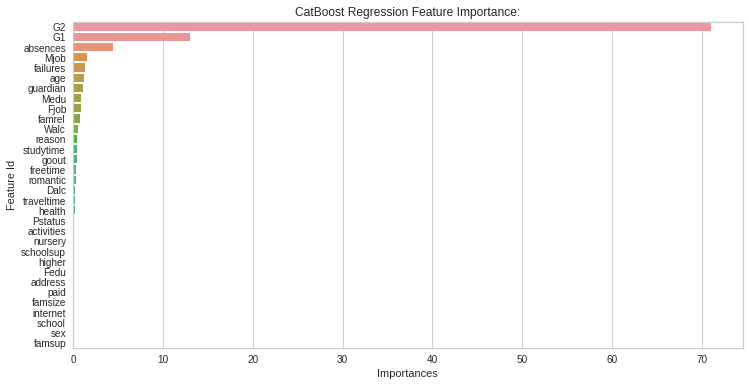

In [34]:
plt.figure(figsize=(12, 6));
sns.barplot(x="Importances", y="Feature Id", data=feature_importance_df);
plt.title('CatBoost Regression Feature Importance:');

In [35]:
shap_pool = cb.Pool(train_features, train_target, cat_features=categorical_features_indices)

shap_values = best_model.get_feature_importance(shap_pool, type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(316, 32)


In [36]:
shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], train_features.iloc[3,:])

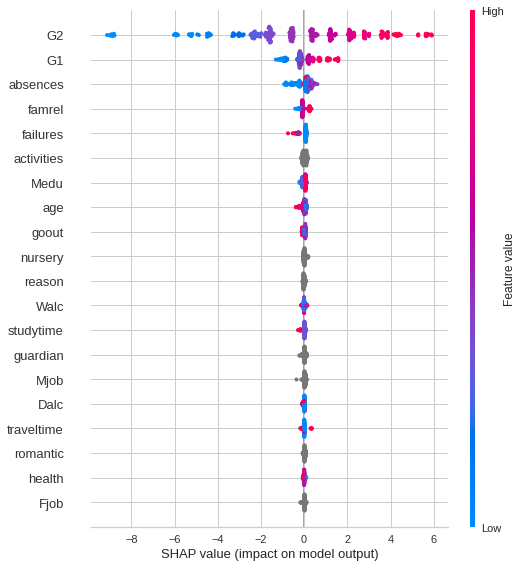

In [37]:
shap.summary_plot(shap_values, train_features)

In [38]:
shap.initjs()
x_small = train_features.iloc[0:200]
shap_small = shap_values[:200]
shap.force_plot(expected_value, shap_small, x_small)

## B) Modeling After the First Trimester (G1) for Final Grade (G3)

In [39]:
features = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
           'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
           'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
           'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
           'Walc', 'health', 'absences', 'G1']
target = ['G3']

In [40]:
train_features = train_df[features]
train_target = train_df[target]

test_features = test_df[features]
test_target = test_df[target]

In [43]:
def objective(trial):

    params = {
                     "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
                     'od_wait': trial.suggest_int('od_wait', 10, 50, step=1),
                     "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.99),
                     "random_strength": trial.suggest_int("random_strength", 1, 10, step=1),
                     "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 50.0),
                     "max_depth": trial.suggest_int("max_depth", 2, 10, step=1),
                     "n_estimators": trial.suggest_int("n_estimators", 100, 3000, step=1),
                     'learning_rate': trial.suggest_loguniform("learning_rate", 0.005, 0.1),
                     "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 60),
                    "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
                    "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
                    "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 10),
                    }

    # Conditional Hyper-Parameters
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)
    elif params["bootstrap_type"] == "MVS":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)


    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=my_seed)

    cv_scores = []

    for train_index, test_index in skf.split(train_features,train_target):

        train_x, valid_x = train_features.iloc[train_index], train_features.iloc[test_index]
        train_y, valid_y = train_target.iloc[train_index], train_target.iloc[test_index]  

        train_pool = cb.Pool(train_x, train_y, cat_features=categorical_features_indices)
        valid_pool = cb.Pool(valid_x, valid_y, cat_features=categorical_features_indices)

        cb_reg_model = cb.CatBoostRegressor(**params, random_state=my_seed)

        cb_reg_optuna = cb_reg_model.fit(train_pool, eval_set=valid_pool, verbose=False, 
                                         early_stopping_rounds=100, use_best_model=True)

        preds = cb_reg_optuna.predict(valid_x)

        MAE = mean_absolute_error(valid_y, preds)

        cv_scores.append(MAE)

    cv_avg_score = np.mean(cv_scores)    

    print('Avg MAE score of CV CatBoost Regression=', cv_avg_score)

    return cv_avg_score

In [44]:
study = optuna.create_study(direction="minimize", sampler = TPESampler(seed=my_seed), study_name="Trimester 1 Regression CV 5")
study.optimize(objective, n_trials=300, n_jobs=-1)

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.829516057207505


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.8038016156225336


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 2.1507086085368217


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7772144851197467


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6265855171739876
Avg MAE score of CV CatBoost Regression= 1.9803285728287143


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 2.0538184460676794


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7726738124542216


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.9890767570120604


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.8903726411551809


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 2.4136861306931188


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.651553644230662


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.674168551085518


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6677701525096544


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6100476032488107


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6267875704489945


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6087681209941507


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6435947095383387


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6318754327211973


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 2.381340706337515


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6549316358942232


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6375858421537006


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6260898371465893


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.620735426038739


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6452368498119097


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.630358611713924


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6400735519246734


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.8210004624236178
Avg MAE score of CV CatBoost Regression= 1.6682376609550484


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6125152659952744


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6644642179068279


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5999910217573674


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6489701639611454


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 2.0587208791588765


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6138910590188265


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5885489759860318


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.618369682388326


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.728992830609723


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7892802163944492


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7300547443401098


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.9066547746410296


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6531867135307508


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.601472857854868


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.800601735131383


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6030624078938907


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.621750694227091


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6125859975155017


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6010494964763502


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7854558926949302


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7419812660474652


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 2.3791492419122315


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.603305216714897


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7417774908039196


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7892007798271568


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6144326366702006


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5957914282146617


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6082857067381326


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6111509874749559


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6608131383625184


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6917048245563948


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.667672686344373


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7096842405960888


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.611770606541543


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6136042066966247


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6110974454783193


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.652319554731792


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7472239811172017


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6491256394592786


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6060795807550605


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6010967041467499


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6094820614105074


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5871204441418647


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6889725137094456


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5989984065565452


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6335196071323583


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.6060116741107575


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6065000476643767


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5894562415721776


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.626774915515893


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7588115564796614


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6288308377883756


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6350135990973957


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.8046907275231046


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.887267263515885


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6073665615559485


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6213035396878432


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5882736440431935


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.634471169078094


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6027879747862712


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6002783602376893


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6979028065272839


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.682288450978089


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.680241188219658


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6488683514050024


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6415446785438554


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6317648611125222


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6130846507457934


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6368936315808351


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6354438009876475


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.8451596783956918


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.827170345814957


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6285713419989527


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5994216108811201


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6569924839283163


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6583099892482642


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6140303855522622


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.636046653296582


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6041283382345248


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 2.0474110466480653


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6032236899463261


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.612952899328576


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6202099688031484


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7031687519790104


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.704929328945773


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6110470648666482


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.610551345954055


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5803056580547712


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.596476176931814


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5856968672603053


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6103370935342505


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6063638271507847


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5757705688082584


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.61142358097482


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5974973467682216


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5865564296014223


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5784020778409524


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5917950086155925


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6450198925285515


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6295101316287695


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6727243181914617


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6459064552364722


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6410790689492774


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6067706973628955


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5958697485422106


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6443520655536599


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5960269914324499


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.596983524595259


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6224994402717303


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.599017803740075


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.605920169997189


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7546182438814462


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.8610832425879806


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.608490366194373


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5998265827837106


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6323898658938127


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.588308095167643


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6009176407195962


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6230620363016086


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6324087766441902


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.596430525133973


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.609326456614473


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6334455691861525


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6083071663979134


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6813694675006334


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5964232282474098


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6189925617526697
Avg MAE score of CV CatBoost Regression= 1.613789374040102


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.593160506606794


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6134572564953307


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.5992103447513561


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6311288721834818


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.61395194706814


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6135535908594207


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7767823390063278


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6126894719379177


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.612992335941217
Avg MAE score of CV CatBoost Regression= 1.5850626090218727


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6260078496164063


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6057696259732217


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6726079340254933


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6289507156987468


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6585250968839502


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5853743208049145


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6356603627617177


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.642496446680053


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6005519358874452


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6550643466688908


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5862526924872644


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.63448841378266


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.617618936929576


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.584637507608126


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6120660329933354


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5951280119688325


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5925133313044841


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5934319774038777


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.585187008226288


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.584213833121303


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6045218417371134


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6030295844239788


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.589786312718756


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.79285173121862


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5929108959151885


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5842192571922564


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5913557874129942


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5921241963884352


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5853775153855103


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5834089160161646


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.599760399937429


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5927696932413145


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.582003976156935


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7537401508536756


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6804672363252133


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6578104056295746


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6009489997704982


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.592282463777948


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.5979585884358172


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.605218332544376


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5953998154501796


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6053275258905149
Avg MAE score of CV CatBoost Regression= 1.5873266489618039


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5972510686406156


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6121136135442846


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5951043003234537


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5854187391676535


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5980588044551256


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5993959180945


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6082050785930675


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5946979932991892


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5935292226713407


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.583049069472537


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5937991806361986


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6008816886396537


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6062229537716053
Avg MAE score of CV CatBoost Regression= 1.6414792214587302


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.5970379767535114


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.568074677492705


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5872953672558507


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5965468350018852


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7380242258814302


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5825394065927543


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5902047064504803


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5830545373792393


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5743264191774202


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5879045010525517


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.581262626522547


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.586534704937419


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.5802350121952196


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5752730836999427


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.583199799745143


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5854293695465607


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5937775672381957


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.590575332892862


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5919483793560107


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5810419735867214


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.585967277251369


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5856113434850676


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.575671022219129


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5853933302232712


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5765381564939696


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5811257363290796


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.661218207771634


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5747425987804353


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5955430578734895


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.583082760899718


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.579008108660703


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.595629152970269


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5926045522741794


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6058181252652286


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.577983047799274


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.578548883425529


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7994780384419513


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.58833212889704


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.596068020205083
Avg MAE score of CV CatBoost Regression= 1.5774385648111537


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.5836687758260293


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.589678976109314


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.585066177295432


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5856280124931323


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5937919436965162


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7257414366945856


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6599198417890915


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.596260050153572


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5751522640376325


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5777794938309246


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.583977205626186


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.670194012877395


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7330318107179075


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5883736081410518


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5941436000988296


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5934676312464813


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.8007272899999038


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5960425650367065


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.575608057270148


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5987011356265257


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.595803081214644


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5896801283144695


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5741159374401128


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5782148421272102


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6108512455043384


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5970549444967144


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.761625975865389


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5718560726639594


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6650177307150937


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6265692637979907


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6140708487892368


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5825312985596098


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.617096124940963


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5916031345228894


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.576653908492958


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.797946468766511


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6063613208366234
Avg MAE score of CV CatBoost Regression= 1.5854831845261006


In [45]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 300
Best trial:
  Value: 1.568074677492705
  Params: 
    loss_function: RMSE
    od_wait: 42
    colsample_bylevel: 0.7770958544643342
    random_strength: 1
    l2_leaf_reg: 43.91107453649701
    max_depth: 5
    n_estimators: 1779
    learning_rate: 0.018390169526991067
    min_data_in_leaf: 37
    boosting_type: Ordered
    bootstrap_type: MVS
    one_hot_max_size: 6
    subsample: 0.7954773831524677


In [46]:
optuna.visualization.plot_optimization_history(study)

In [47]:
best_model = cb.CatBoostRegressor()
best_model = best_model.set_params(**study.best_params)
best_model = best_model.fit(train_features, train_target, cat_features= categorical_features_indices, verbose=False, early_stopping_rounds=100)


preds = best_model.predict(test_features)

MAE = mean_absolute_error(test_target, preds)

print('MAE score of CatBoost =', MAE)

MAE score of CatBoost = 1.8472794490562812


# 2) Classification Modeling (Pass/Fail)

## A) Modeling After the Second Trimester (G1, G2) for Pass/Fail

In [28]:
train_df , test_df = train_test_split(df, test_size=0.2, random_state=my_seed, stratify=df['failures'])

In [29]:
features = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
           'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
           'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
           'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
           'Walc', 'health', 'absences', 'G1', 'G2']
target = ['pass']

In [30]:
train_features = train_df[features]
train_target = train_df[target]

test_features = test_df[features]
test_target = test_df[target]

In [31]:
def objective(trial):

    params = {
        'iterations' : trial.suggest_int('iterations', 50, 300),
        'depth' : trial.suggest_int('depth', 2, 10),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    }

    # Conditional Hyper-Parameters
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)
    elif params["bootstrap_type"] == "MVS":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=my_seed)

    cv_scores = []

    for train_index, test_index in skf.split(train_features,train_target):

        train_x, valid_x = train_features.iloc[train_index], train_features.iloc[test_index]
        train_y, valid_y = train_target.iloc[train_index], train_target.iloc[test_index]  

        train_pool = cb.Pool(train_x, train_y, cat_features=categorical_features_indices)
        valid_pool = cb.Pool(valid_x, valid_y, cat_features=categorical_features_indices)

        cb_class_model = cb.CatBoostClassifier(**params, random_state=my_seed)

        cb_class_optuna = cb_class_model.fit(train_pool, eval_set=valid_pool, verbose=False, 
                                         early_stopping_rounds=100, use_best_model=True)

        preds = cb_class_optuna.predict(valid_x)

        ROC_AUC = roc_auc_score(valid_y, preds)

        cv_scores.append(ROC_AUC)

    cv_avg_score = np.mean(cv_scores)    

    print('Avg ROC AUC score of CV CatBoost Classification=', cv_avg_score)

    return cv_avg_score

In [32]:
study = optuna.create_study(direction="maximize", sampler = TPESampler(seed=my_seed), study_name="Trimester 2 Classification CV 5")
study.optimize(objective, n_trials=300, n_jobs=-1)

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8726111287086897
Avg ROC AUC score of CV CatBoost Classification= 0.8479938760426566


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9056699398162813
Avg ROC AUC score of CV CatBoost Classification= 0.919306303452645
Avg ROC AUC score of CV CatBoost Classification= 0.8618466898954702


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9078925139900749
Avg ROC AUC score of CV CatBoost Classification= 0.8912258473234083
Avg ROC AUC score of CV CatBoost Classification= 0.9125963467426882
Avg ROC AUC score of CV CatBoost Classification= 0.5
Avg ROC AUC score of CV CatBoost Classification= 0.6829004329004329
Avg ROC AUC score of CV CatBoost Classification= 0.9076760637736248
Avg ROC AUC score of CV CatBoost Classification= 0.9169253510716926
Avg ROC AUC score of CV CatBoost Classification= 0.9148189209164819
Avg ROC AUC score of CV CatBoost Classification= 0.9121634463097879
Avg ROC AUC score of CV CatBoost Classification= 0.9124379685355295
Avg ROC AUC score of CV CatBoost Classification= 0.9148189209164819


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9195808256783866
Avg ROC AUC score of CV CatBoost Classification= 0.9078925139900749
Avg ROC AUC score of CV CatBoost Classification= 0.9150353711329322
Avg ROC AUC score of CV CatBoost Classification= 0.8866223207686621
Avg ROC AUC score of CV CatBoost Classification= 0.8895945517896736
Avg ROC AUC score of CV CatBoost Classification= 0.8365800865800865
Avg ROC AUC score of CV CatBoost Classification= 0.9007496568472178
Avg ROC AUC score of CV CatBoost Classification= 0.912496040544821
Avg ROC AUC score of CV CatBoost Classification= 0.9193643754619364
Avg ROC AUC score of CV CatBoost Classification= 0.9078925139900749
Avg ROC AUC score of CV CatBoost Classification= 0.9097824939288355
Avg ROC AUC score of CV CatBoost Classification= 0.9054534895998311
Avg ROC AUC score of CV CatBoost Classification= 0.9241262802238411
Avg ROC AUC score of CV CatBoost Classification= 0.8866223207686621
Avg ROC AUC score of CV CatBoost Classification= 

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9076760637736246
Avg ROC AUC score of CV CatBoost Classification= 0.921961778059339
Avg ROC AUC score of CV CatBoost Classification= 0.9219037060500475


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.916983423080984
Avg ROC AUC score of CV CatBoost Classification= 0.9312691373666983
Avg ROC AUC score of CV CatBoost Classification= 0.9217453278428888
Avg ROC AUC score of CV CatBoost Classification= 0.8938232499208111
Avg ROC AUC score of CV CatBoost Classification= 0.9058863900327315
Avg ROC AUC score of CV CatBoost Classification= 0.9217453278428888
Avg ROC AUC score of CV CatBoost Classification= 0.9078925139900751
Avg ROC AUC score of CV CatBoost Classification= 0.9336500897476506
Avg ROC AUC score of CV CatBoost Classification= 0.9196388976876781
Avg ROC AUC score of CV CatBoost Classification= 0.9174163235138846
Avg ROC AUC score of CV CatBoost Classification= 0.9052951113926723
Avg ROC AUC score of CV CatBoost Classification= 0.9147608489071903
Avg ROC AUC score of CV CatBoost Classification= 0.9148189209164819
Avg ROC AUC score of CV CatBoost Classification= 0.900966107063668
Avg ROC AUC score of CV CatBoost Classification= 0

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9217453278428888
Avg ROC AUC score of CV CatBoost Classification= 0.916983423080984
Avg ROC AUC score of CV CatBoost Classification= 0.9102734663710272
Avg ROC AUC score of CV CatBoost Classification= 0.9197392038855453
Avg ROC AUC score of CV CatBoost Classification= 0.919797275894837
Avg ROC AUC score of CV CatBoost Classification= 0.9078344419807834
Avg ROC AUC score of CV CatBoost Classification= 0.9217453278428888
Avg ROC AUC score of CV CatBoost Classification= 0.9195227536690951
Avg ROC AUC score of CV CatBoost Classification= 0.9267236828212437
Avg ROC AUC score of CV CatBoost Classification= 0.9147608489071904
Avg ROC AUC score of CV CatBoost Classification= 0.9102153943617358
Avg ROC AUC score of CV CatBoost Classification= 0.9148189209164819
Avg ROC AUC score of CV CatBoost Classification= 0.895987752085313
Avg ROC AUC score of CV CatBoost Classification= 0.9124379685355295
Avg ROC AUC score of CV CatBoost Classification= 0.

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9241262802238411
Avg ROC AUC score of CV CatBoost Classification= 0.9312691373666985
Avg ROC AUC score of CV CatBoost Classification= 0.9267236828212437
Avg ROC AUC score of CV CatBoost Classification= 0.9171998732974342
Avg ROC AUC score of CV CatBoost Classification= 0.935814591912153
Avg ROC AUC score of CV CatBoost Classification= 0.9171418012881427
Avg ROC AUC score of CV CatBoost Classification= 0.919797275894837
Avg ROC AUC score of CV CatBoost Classification= 0.9242846584309999
Avg ROC AUC score of CV CatBoost Classification= 0.9217453278428888
Avg ROC AUC score of CV CatBoost Classification= 0.90291415901172
Avg ROC AUC score of CV CatBoost Classification= 0.9171998732974342
Avg ROC AUC score of CV CatBoost Classification= 0.9336500897476506
Avg ROC AUC score of CV CatBoost Classification= 0.9126544187519796
Avg ROC AUC score of CV CatBoost Classification= 0.9268820610284024
Avg ROC AUC score of CV CatBoost Classification= 0.9

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9147608489071903
Avg ROC AUC score of CV CatBoost Classification= 0.9148189209164819
Avg ROC AUC score of CV CatBoost Classification= 0.9147608489071903
Avg ROC AUC score of CV CatBoost Classification= 0.9171998732974342
Avg ROC AUC score of CV CatBoost Classification= 0.9192482314433533
Avg ROC AUC score of CV CatBoost Classification= 0.912379896526238
Avg ROC AUC score of CV CatBoost Classification= 0.9031306092281703
Avg ROC AUC score of CV CatBoost Classification= 0.9098405659381269
Avg ROC AUC score of CV CatBoost Classification= 0.9241262802238411
Avg ROC AUC score of CV CatBoost Classification= 0.9290465631929046
Avg ROC AUC score of CV CatBoost Classification= 0.9150353711329322
Avg ROC AUC score of CV CatBoost Classification= 0.9312691373666983
Avg ROC AUC score of CV CatBoost Classification= 0.9102734663710272
Avg ROC AUC score of CV CatBoost Classification= 0.9288881849857459
Avg ROC AUC score of CV CatBoost Classification= 

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9171998732974342
Avg ROC AUC score of CV CatBoost Classification= 0.9195808256783866
Avg ROC AUC score of CV CatBoost Classification= 0.9216872558335973
Avg ROC AUC score of CV CatBoost Classification= 0.9121053743004962
Avg ROC AUC score of CV CatBoost Classification= 0.9288881849857459


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9148189209164819
Avg ROC AUC score of CV CatBoost Classification= 0.9148189209164819


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9171998732974342
Avg ROC AUC score of CV CatBoost Classification= 0.9010241790729596
Avg ROC AUC score of CV CatBoost Classification= 0.919306303452645
Avg ROC AUC score of CV CatBoost Classification= 0.9055115616091225


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9267236828212437
Avg ROC AUC score of CV CatBoost Classification= 0.9148189209164819
Avg ROC AUC score of CV CatBoost Classification= 0.912379896526238
Avg ROC AUC score of CV CatBoost Classification= 0.9216872558335973
Avg ROC AUC score of CV CatBoost Classification= 0.9216872558335973
Avg ROC AUC score of CV CatBoost Classification= 0.9195808256783866
Avg ROC AUC score of CV CatBoost Classification= 0.9265072326047935
Avg ROC AUC score of CV CatBoost Classification= 0.9100570161545771
Avg ROC AUC score of CV CatBoost Classification= 0.9102153943617358
Avg ROC AUC score of CV CatBoost Classification= 0.9078925139900751
Avg ROC AUC score of CV CatBoost Classification= 0.9127124907612713
Avg ROC AUC score of CV CatBoost Classification= 0.9176327737303348
Avg ROC AUC score of CV CatBoost Classification= 0.9076179917643332
Avg ROC AUC score of CV CatBoost Classification= 0.9007496568472178
Avg ROC AUC score of CV CatBoost Classification= 

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.921961778059339
Avg ROC AUC score of CV CatBoost Classification= 0.9241262802238411
Avg ROC AUC score of CV CatBoost Classification= 0.9055115616091227
Avg ROC AUC score of CV CatBoost Classification= 0.9123798965262381
Avg ROC AUC score of CV CatBoost Classification= 0.9221201562664977
Avg ROC AUC score of CV CatBoost Classification= 0.9265653046140852
Avg ROC AUC score of CV CatBoost Classification= 0.9217453278428888
Avg ROC AUC score of CV CatBoost Classification= 0.9223946784922393
Avg ROC AUC score of CV CatBoost Classification= 0.9172579453067258
Avg ROC AUC score of CV CatBoost Classification= 0.9076760637736248
Avg ROC AUC score of CV CatBoost Classification= 0.919306303452645
Avg ROC AUC score of CV CatBoost Classification= 0.916983423080984
Avg ROC AUC score of CV CatBoost Classification= 0.916983423080984
Avg ROC AUC score of CV CatBoost Classification= 0.9173582515045929
Avg ROC AUC score of CV CatBoost Classification= 0.9

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9193643754619364
Avg ROC AUC score of CV CatBoost Classification= 0.9195808256783866
Avg ROC AUC score of CV CatBoost Classification= 0.9076760637736248
Avg ROC AUC score of CV CatBoost Classification= 0.9052370393833808


In [33]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 300
Best trial:
  Value: 0.935814591912153
  Params: 
    iterations: 276
    depth: 10
    learning_rate: 0.2324634333944344
    random_strength: 5
    od_type: IncToDec
    objective: CrossEntropy
    colsample_bylevel: 0.09087593400873209
    boosting_type: Ordered
    bootstrap_type: MVS
    subsample: 0.7517580706110801


In [34]:
optuna.visualization.plot_optimization_history(study)

In [35]:
best_model = cb.CatBoostClassifier()
best_model = best_model.set_params(**study.best_params)
best_model = best_model.fit(train_features, train_target, cat_features= categorical_features_indices, verbose=False, early_stopping_rounds=100)

preds = best_model.predict(test_features)

ROC_AUC_Score = roc_auc_score(test_target, preds)

print('ROC AUC Score of CatBoost =', ROC_AUC_Score)

ROC AUC Score of CatBoost = 0.8940217391304348


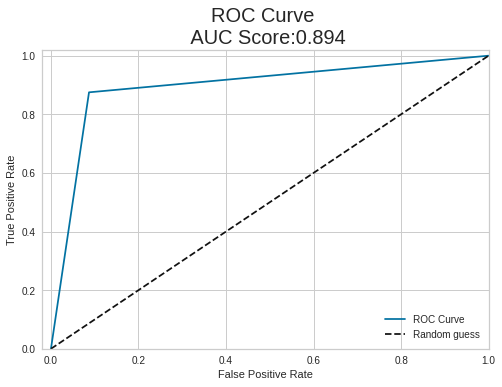

In [36]:

fpr, tpr, thresholds = roc_curve(test_target, preds)

# create plot
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
g = plt.xlabel('False Positive Rate')
g = plt.ylabel('True Positive Rate')
g = plt.title('ROC Curve \n AUC Score:{0:.3f}'.format(roc_auc_score(test_target, preds)), fontsize=20)
g = plt.xlim([-0.02, 1])
g = plt.ylim([0, 1.02])
g = plt.legend(loc="lower right")

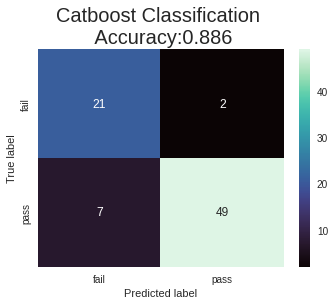

True Negatives:  21
False Positives:  2
False Negatives:  7
True Positives:  49


In [37]:
cm = confusion_matrix(test_target, preds)

cm_df = pd.DataFrame(cm,
                     index = ['fail','pass'],
                     columns = ['fail','pass'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap='mako')
plt.title('Catboost Classification \n Accuracy:{0:.3f}'.format(accuracy_score(test_target, preds)), fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(test_target, preds).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

In [38]:
pd.DataFrame(preds).value_counts()

1    51
0    28
dtype: int64

## B) Modeling After the First Trimester (G1) for Pass/Fail


In [39]:
features = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
           'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
           'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
           'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
           'Walc', 'health', 'absences', 'G1']
target = ['pass']

In [40]:
train_features = train_df[features]
train_target = train_df[target]

test_features = test_df[features]
test_target = test_df[target]

In [41]:
def objective(trial):

    params = {
        'iterations' : trial.suggest_int('iterations', 50, 300),
        'depth' : trial.suggest_int('depth', 2, 10),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    }

    # Conditional Hyper-Parameters
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)
    elif params["bootstrap_type"] == "MVS":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=my_seed)

    cv_scores = []

    for train_index, test_index in skf.split(train_features,train_target):

        train_x, valid_x = train_features.iloc[train_index], train_features.iloc[test_index]
        train_y, valid_y = train_target.iloc[train_index], train_target.iloc[test_index]  

        train_pool = cb.Pool(train_x, train_y, cat_features=categorical_features_indices)
        valid_pool = cb.Pool(valid_x, valid_y, cat_features=categorical_features_indices)

        cb_class_model = cb.CatBoostClassifier(**params, random_state=my_seed)

        cb_class_optuna = cb_class_model.fit(train_pool, eval_set=valid_pool, verbose=False, 
                                         early_stopping_rounds=100, use_best_model=True)

        preds = cb_class_optuna.predict(valid_x)

        ROC_AUC = roc_auc_score(valid_y, preds)

        cv_scores.append(ROC_AUC)

    cv_avg_score = np.mean(cv_scores)    

    print('Avg ROC AUC score of CV CatBoost Classification=', cv_avg_score)

    return cv_avg_score

In [42]:
study = optuna.create_study(direction="maximize", sampler = TPESampler(seed=my_seed), study_name="Trimester 1 Classification")
study.optimize(objective, n_trials=300, n_jobs=-1)

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.656060606060606
Avg ROC AUC score of CV CatBoost Classification= 0.5
Avg ROC AUC score of CV CatBoost Classification= 0.7623798965262379
Avg ROC AUC score of CV CatBoost Classification= 0.5
Avg ROC AUC score of CV CatBoost Classification= 0.7482103262591068
Avg ROC AUC score of CV CatBoost Classification= 0.6517316017316018
Avg ROC AUC score of CV CatBoost Classification= 0.7399852180339985


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.5


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.751224791468694
Avg ROC AUC score of CV CatBoost Classification= 0.5378787878787878
Avg ROC AUC score of CV CatBoost Classification= 0.8023070425509449
Avg ROC AUC score of CV CatBoost Classification= 0.7702882483370288
Avg ROC AUC score of CV CatBoost Classification= 0.7884700665188472
Avg ROC AUC score of CV CatBoost Classification= 0.8043712385175799
Avg ROC AUC score of CV CatBoost Classification= 0.7481522542498154


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7861894203357618
Avg ROC AUC score of CV CatBoost Classification= 0.7905764966740578
Avg ROC AUC score of CV CatBoost Classification= 0.7814697497624328
Avg ROC AUC score of CV CatBoost Classification= 0.7982103262591067
Avg ROC AUC score of CV CatBoost Classification= 0.8018741421180445
Avg ROC AUC score of CV CatBoost Classification= 0.5928571428571429


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7572853975293001
Avg ROC AUC score of CV CatBoost Classification= 0.7741262802238412


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8143860204835814
Avg ROC AUC score of CV CatBoost Classification= 0.783359729701193


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8185988807940026
Avg ROC AUC score of CV CatBoost Classification= 0.7765494667933692
Avg ROC AUC score of CV CatBoost Classification= 0.7513990074965685
Avg ROC AUC score of CV CatBoost Classification= 0.7994931897370923


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7382536163023967
Avg ROC AUC score of CV CatBoost Classification= 0.7788881849857459
Avg ROC AUC score of CV CatBoost Classification= 0.8003167564143172
Avg ROC AUC score of CV CatBoost Classification= 0.7237514518002321


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8002006123957344
Avg ROC AUC score of CV CatBoost Classification= 0.7806620209059234
Avg ROC AUC score of CV CatBoost Classification= 0.7762327103790517
Avg ROC AUC score of CV CatBoost Classification= 0.8142698764649984
Avg ROC AUC score of CV CatBoost Classification= 0.7065357406820821
Avg ROC AUC score of CV CatBoost Classification= 0.7575599197550418
Avg ROC AUC score of CV CatBoost Classification= 0.7929574490550101
Avg ROC AUC score of CV CatBoost Classification= 0.7344155844155844
Avg ROC AUC score of CV CatBoost Classification= 0.7767817548305352


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7647608489071904
Avg ROC AUC score of CV CatBoost Classification= 0.7927832330271356


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8167089008552424
Avg ROC AUC score of CV CatBoost Classification= 0.8022067363530778
Avg ROC AUC score of CV CatBoost Classification= 0.80291415901172


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7925667828106853


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.748410938654841
Avg ROC AUC score of CV CatBoost Classification= 0.7426406926406927


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7399852180339985
Avg ROC AUC score of CV CatBoost Classification= 0.7907929468905079
Avg ROC AUC score of CV CatBoost Classification= 0.8191479252454863


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7761746383697604
Avg ROC AUC score of CV CatBoost Classification= 0.7651356773307993
Avg ROC AUC score of CV CatBoost Classification= 0.7747175588639005
Avg ROC AUC score of CV CatBoost Classification= 0.7761746383697604
Avg ROC AUC score of CV CatBoost Classification= 0.7843997465948686


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7667511350438179
Avg ROC AUC score of CV CatBoost Classification= 0.7842413683877097
Avg ROC AUC score of CV CatBoost Classification= 0.7929996832435857
Avg ROC AUC score of CV CatBoost Classification= 0.7813694435645655
Avg ROC AUC score of CV CatBoost Classification= 0.7789884911836131
Avg ROC AUC score of CV CatBoost Classification= 0.7838084679548094
Avg ROC AUC score of CV CatBoost Classification= 0.7882958504909724
Avg ROC AUC score of CV CatBoost Classification= 0.7743849646288671
Avg ROC AUC score of CV CatBoost Classification= 0.7905184246647661
Avg ROC AUC score of CV CatBoost Classification= 0.7863477985429205
Avg ROC AUC score of CV CatBoost Classification= 0.80437123851758
Avg ROC AUC score of CV CatBoost Classification= 0.7122795903283707
Avg ROC AUC score of CV CatBoost Classification= 0.7411097033048252
Avg ROC AUC score of CV CatBoost Classification= 0.7796378418329638
Avg ROC AUC score of CV CatBoost Classification= 0

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7959296800760215
Avg ROC AUC score of CV CatBoost Classification= 0.7957132298595715
Avg ROC AUC score of CV CatBoost Classification= 0.8072431633407243
Avg ROC AUC score of CV CatBoost Classification= 0.7861894203357618
Avg ROC AUC score of CV CatBoost Classification= 0.795496779643121
Avg ROC AUC score of CV CatBoost Classification= 0.8070847851335656
Avg ROC AUC score of CV CatBoost Classification= 0.7740682082145497
Avg ROC AUC score of CV CatBoost Classification= 0.7955548516524127
Avg ROC AUC score of CV CatBoost Classification= 0.8186569528032944
Avg ROC AUC score of CV CatBoost Classification= 0.7525815647766868
Avg ROC AUC score of CV CatBoost Classification= 0.7875303558230388
Avg ROC AUC score of CV CatBoost Classification= 0.7792630134093548
Avg ROC AUC score of CV CatBoost Classification= 0.8186569528032942
Avg ROC AUC score of CV CatBoost Classification= 0.7704466265441875
Avg ROC AUC score of CV CatBoost Classification= 

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.6704466265441875
Avg ROC AUC score of CV CatBoost Classification= 0.7866803927779538
Avg ROC AUC score of CV CatBoost Classification= 0.7622215183190792
Avg ROC AUC score of CV CatBoost Classification= 0.792841305036427


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7953806356245381
Avg ROC AUC score of CV CatBoost Classification= 0.7899693802132826
Avg ROC AUC score of CV CatBoost Classification= 0.7571270193221414
Avg ROC AUC score of CV CatBoost Classification= 0.8047038327526131
Avg ROC AUC score of CV CatBoost Classification= 0.7953384014359623
Avg ROC AUC score of CV CatBoost Classification= 0.7698395100834124
Avg ROC AUC score of CV CatBoost Classification= 0.7902439024390244
Avg ROC AUC score of CV CatBoost Classification= 0.7645443986907402
Avg ROC AUC score of CV CatBoost Classification= 0.764428254672157
Avg ROC AUC score of CV CatBoost Classification= 0.8117305458768873
Avg ROC AUC score of CV CatBoost Classification= 0.7789884911836131
Avg ROC AUC score of CV CatBoost Classification= 0.7741685144124169
Avg ROC AUC score of CV CatBoost Classification= 0.7605902227853447
Avg ROC AUC score of CV CatBoost Classification= 0.7971703093654313
Avg ROC AUC score of CV CatBoost Classification= 

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7697392038855454
Avg ROC AUC score of CV CatBoost Classification= 0.7696811318762538
Avg ROC AUC score of CV CatBoost Classification= 0.7712543554006968
Avg ROC AUC score of CV CatBoost Classification= 0.8088586210537431
Avg ROC AUC score of CV CatBoost Classification= 0.7881374722838137
Avg ROC AUC score of CV CatBoost Classification= 0.7695808256783867


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7907348748812163
Avg ROC AUC score of CV CatBoost Classification= 0.795280329426671


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7537218878682292
Avg ROC AUC score of CV CatBoost Classification= 0.8049202829690634


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7529563932002956
Avg ROC AUC score of CV CatBoost Classification= 0.7532309154260375
Avg ROC AUC score of CV CatBoost Classification= 0.8186569528032942
Avg ROC AUC score of CV CatBoost Classification= 0.8213124274099883
Avg ROC AUC score of CV CatBoost Classification= 0.7931738992714602
Avg ROC AUC score of CV CatBoost Classification= 0.79732868757259


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7860891141378946
Avg ROC AUC score of CV CatBoost Classification= 0.8001583782071588
Avg ROC AUC score of CV CatBoost Classification= 0.7981522542498153
Avg ROC AUC score of CV CatBoost Classification= 0.7928993770457184
Avg ROC AUC score of CV CatBoost Classification= 0.7938813219301024
Avg ROC AUC score of CV CatBoost Classification= 0.806910569105691
Avg ROC AUC score of CV CatBoost Classification= 0.7958293738781543
Avg ROC AUC score of CV CatBoost Classification= 0.799883855981417
Avg ROC AUC score of CV CatBoost Classification= 0.8094076655052265
Avg ROC AUC score of CV CatBoost Classification= 0.8071850913314329
Avg ROC AUC score of CV CatBoost Classification= 0.8040386442825467
Avg ROC AUC score of CV CatBoost Classification= 0.8026977087952696
Avg ROC AUC score of CV CatBoost Classification= 0.816276000422342


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8091912152887761
Avg ROC AUC score of CV CatBoost Classification= 0.7977193538169148
Avg ROC AUC score of CV CatBoost Classification= 0.7981522542498153
Avg ROC AUC score of CV CatBoost Classification= 0.8093495934959349


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7673582515045929
Avg ROC AUC score of CV CatBoost Classification= 0.7956551578502798


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7745011086474503
Avg ROC AUC score of CV CatBoost Classification= 0.762754724949847


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8022648083623694
Avg ROC AUC score of CV CatBoost Classification= 0.7880213282652306


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7978777320240734
Avg ROC AUC score of CV CatBoost Classification= 0.8020325203252033
Avg ROC AUC score of CV CatBoost Classification= 0.7720620842572062
Avg ROC AUC score of CV CatBoost Classification= 0.8000422341885756


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7887868229331645
Avg ROC AUC score of CV CatBoost Classification= 0.8208214549677963
Avg ROC AUC score of CV CatBoost Classification= 0.7742846584309998
Avg ROC AUC score of CV CatBoost Classification= 0.7999260901699927
Avg ROC AUC score of CV CatBoost Classification= 0.7858568261007285
Avg ROC AUC score of CV CatBoost Classification= 0.7897529299968324
Avg ROC AUC score of CV CatBoost Classification= 0.7859729701193114
Avg ROC AUC score of CV CatBoost Classification= 0.7902439024390244
Avg ROC AUC score of CV CatBoost Classification= 0.8000422341885758


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7806039488966319
Avg ROC AUC score of CV CatBoost Classification= 0.5632034632034632
Avg ROC AUC score of CV CatBoost Classification= 0.7652518213493824
Avg ROC AUC score of CV CatBoost Classification= 0.7720198500686306
Avg ROC AUC score of CV CatBoost Classification= 0.8306197867173477
Avg ROC AUC score of CV CatBoost Classification= 0.8022067363530778
Avg ROC AUC score of CV CatBoost Classification= 0.7745591806567416
Avg ROC AUC score of CV CatBoost Classification= 0.795496779643121
Avg ROC AUC score of CV CatBoost Classification= 0.8033470594446204
Avg ROC AUC score of CV CatBoost Classification= 0.8163340724316335
Avg ROC AUC score of CV CatBoost Classification= 0.8002006123957344
Avg ROC AUC score of CV CatBoost Classification= 0.797819660014782
Avg ROC AUC score of CV CatBoost Classification= 0.7974448315911731


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7862474923450533


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7904603526554747
Avg ROC AUC score of CV CatBoost Classification= 0.7148611551050574
Avg ROC AUC score of CV CatBoost Classification= 0.7996093337556752
Avg ROC AUC score of CV CatBoost Classification= 0.795987752085313
Avg ROC AUC score of CV CatBoost Classification= 0.7928993770457186
Avg ROC AUC score of CV CatBoost Classification= 0.8141114982578397
Avg ROC AUC score of CV CatBoost Classification= 0.7741262802238412
Avg ROC AUC score of CV CatBoost Classification= 0.7907929468905079
Avg ROC AUC score of CV CatBoost Classification= 0.8069686411149826
Avg ROC AUC score of CV CatBoost Classification= 0.7976032097983318
Avg ROC AUC score of CV CatBoost Classification= 0.7835339457290675
Avg ROC AUC score of CV CatBoost Classification= 0.7724527505015308
Avg ROC AUC score of CV CatBoost Classification= 0.8045876887340302
Avg ROC AUC score of CV CatBoost Classification= 0.7885703727167142
Avg ROC AUC score of CV CatBoost Classification= 

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7906187308626332
Avg ROC AUC score of CV CatBoost Classification= 0.7828845950797171
Avg ROC AUC score of CV CatBoost Classification= 0.7656266497729913


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7905184246647661


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7859148981100201
Avg ROC AUC score of CV CatBoost Classification= 0.8024231865695279
Avg ROC AUC score of CV CatBoost Classification= 0.7747175588639004
Avg ROC AUC score of CV CatBoost Classification= 0.7879790940766551
Avg ROC AUC score of CV CatBoost Classification= 0.8053531834019638


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7862474923450534
Avg ROC AUC score of CV CatBoost Classification= 0.7222785344736563


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7747175588639005


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7886284447260057
Avg ROC AUC score of CV CatBoost Classification= 0.8286717347692957
Avg ROC AUC score of CV CatBoost Classification= 0.7950058072009292


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7839246119733925
Avg ROC AUC score of CV CatBoost Classification= 0.8184985745961356
Avg ROC AUC score of CV CatBoost Classification= 0.7982103262591067
Avg ROC AUC score of CV CatBoost Classification= 0.795496779643121
Avg ROC AUC score of CV CatBoost Classification= 0.8144440924928731
Avg ROC AUC score of CV CatBoost Classification= 0.7889029669517476
Avg ROC AUC score of CV CatBoost Classification= 0.8046457607433217
Avg ROC AUC score of CV CatBoost Classification= 0.8002586844050258
Avg ROC AUC score of CV CatBoost Classification= 0.7867384647872452
Avg ROC AUC score of CV CatBoost Classification= 0.7791627072114876
Avg ROC AUC score of CV CatBoost Classification= 0.8092915214866434
Avg ROC AUC score of CV CatBoost Classification= 0.8074596135571745
Avg ROC AUC score of CV CatBoost Classification= 0.7767236828212439


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8045876887340302
Avg ROC AUC score of CV CatBoost Classification= 0.7839246119733925
Avg ROC AUC score of CV CatBoost Classification= 0.7906768028719249
Avg ROC AUC score of CV CatBoost Classification= 0.7859729701193116


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.797935804033365
Avg ROC AUC score of CV CatBoost Classification= 0.6080086580086579
Avg ROC AUC score of CV CatBoost Classification= 0.7936648717136522
Avg ROC AUC score of CV CatBoost Classification= 0.7788881849857459


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7840249181712597
Avg ROC AUC score of CV CatBoost Classification= 0.7853236194699609
Avg ROC AUC score of CV CatBoost Classification= 0.8048041389504805
Avg ROC AUC score of CV CatBoost Classification= 0.794905501003062


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7995512617463837
Avg ROC AUC score of CV CatBoost Classification= 0.7578344419807834
Avg ROC AUC score of CV CatBoost Classification= 0.7695808256783867
Avg ROC AUC score of CV CatBoost Classification= 0.8051367331855136


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8060025340513144
Avg ROC AUC score of CV CatBoost Classification= 0.8065357406820821
Avg ROC AUC score of CV CatBoost Classification= 0.8141695702671312


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7601150881638686
Avg ROC AUC score of CV CatBoost Classification= 0.7792630134093548
Avg ROC AUC score of CV CatBoost Classification= 0.7885123007074227
Avg ROC AUC score of CV CatBoost Classification= 0.7861313483264704
Avg ROC AUC score of CV CatBoost Classification= 0.8071850913314329
Avg ROC AUC score of CV CatBoost Classification= 0.8212543554006968
Avg ROC AUC score of CV CatBoost Classification= 0.778772040967163
Avg ROC AUC score of CV CatBoost Classification= 0.7833755675219091
Avg ROC AUC score of CV CatBoost Classification= 0.7977193538169148
Avg ROC AUC score of CV CatBoost Classification= 0.8143279484742898
Avg ROC AUC score of CV CatBoost Classification= 0.7925667828106853
Avg ROC AUC score of CV CatBoost Classification= 0.7882958504909723
Avg ROC AUC score of CV CatBoost Classification= 0.806419596663499
Avg ROC AUC score of CV CatBoost Classification= 0.7885123007074227
Avg ROC AUC score of CV CatBoost Classification= 0

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7765494667933693
Avg ROC AUC score of CV CatBoost Classification= 0.7933903494879104
Avg ROC AUC score of CV CatBoost Classification= 0.7856403758842784
Avg ROC AUC score of CV CatBoost Classification= 0.8022067363530778
Avg ROC AUC score of CV CatBoost Classification= 0.8090750712701933
Avg ROC AUC score of CV CatBoost Classification= 0.781427515573857
Avg ROC AUC score of CV CatBoost Classification= 0.5818181818181818
Avg ROC AUC score of CV CatBoost Classification= 0.7670837292788513
Avg ROC AUC score of CV CatBoost Classification= 0.8095079717030934
Avg ROC AUC score of CV CatBoost Classification= 0.816867279062401
Avg ROC AUC score of CV CatBoost Classification= 0.8093495934959349
Avg ROC AUC score of CV CatBoost Classification= 0.8093495934959349
Avg ROC AUC score of CV CatBoost Classification= 0.7995512617463837
Avg ROC AUC score of CV CatBoost Classification= 0.7528560870024286
Avg ROC AUC score of CV CatBoost Classification= 0

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.790301974448316
Avg ROC AUC score of CV CatBoost Classification= 0.8022067363530778
Avg ROC AUC score of CV CatBoost Classification= 0.8068524970963995
Avg ROC AUC score of CV CatBoost Classification= 0.7938813219301023


In [43]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 300
Best trial:
  Value: 0.8306197867173477
  Params: 
    iterations: 179
    depth: 2
    learning_rate: 0.25443297420373756
    random_strength: 63
    od_type: Iter
    objective: CrossEntropy
    colsample_bylevel: 0.09535381304317513
    boosting_type: Ordered
    bootstrap_type: Bayesian
    bagging_temperature: 3.790450324107767


In [44]:
optuna.visualization.plot_optimization_history(study)

In [45]:
best_model = cb.CatBoostClassifier()
best_model = best_model.set_params(**study.best_params)
best_model = best_model.fit(train_features, train_target, cat_features= categorical_features_indices, verbose=False, early_stopping_rounds=100)

preds = best_model.predict(test_features)

ROC_AUC_Score = roc_auc_score(test_target, preds)

print('ROC AUC Score of CatBoost =', ROC_AUC_Score)

ROC AUC Score of CatBoost = 0.8684006211180123


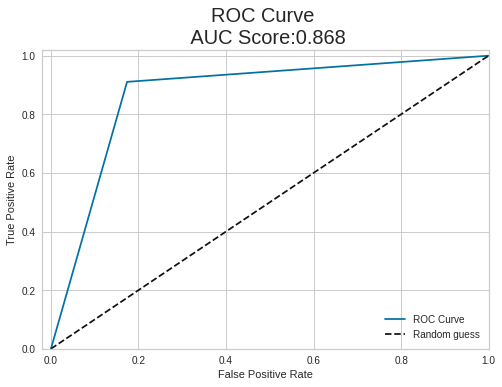

In [46]:

fpr, tpr, thresholds = roc_curve(test_target, preds)

# create plot
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
g = plt.xlabel('False Positive Rate')
g = plt.ylabel('True Positive Rate')
g = plt.title('ROC Curve \n AUC Score:{0:.3f}'.format(roc_auc_score(test_target, preds)), fontsize=20)
g = plt.xlim([-0.02, 1])
g = plt.ylim([0, 1.02])
g = plt.legend(loc="lower right")

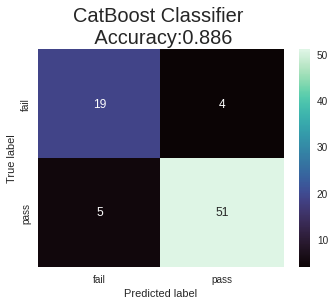

True Negatives:  19
False Positives:  4
False Negatives:  5
True Positives:  51


In [47]:
cm = confusion_matrix(test_target, preds)

cm_df = pd.DataFrame(cm,
                     index = ['fail','pass'],
                     columns = ['fail','pass'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap='mako')
plt.title('CatBoost Classifier \n Accuracy:{0:.3f}'.format(accuracy_score(test_target, preds)), fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(test_target, preds).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

In [48]:
pd.DataFrame(preds).value_counts()

1    55
0    24
dtype: int64

# 3) Multi Classification Modeling (Letter Grade)

## A) Modeling After the Second Trimester (G1, G2) for Letter Grade (A, B, C, D, F)

In [40]:
train_df , test_df = train_test_split(df, test_size=0.2, random_state=my_seed, stratify=df['Grade'])

In [41]:
features = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
           'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
           'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
           'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
           'Walc', 'health', 'absences', 'G1', 'G2']
target = ['Grade']

In [42]:
train_features = train_df[features]
train_target = train_df[target]

test_features = test_df[features]
test_target = test_df[target]

In [43]:
def objective(trial):

    params = {

        'iterations' : trial.suggest_int('iterations', 50, 300),
        'depth' : trial.suggest_int('depth', 2, 10),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    }

    # Conditional Hyper-Parameters
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)
    elif params["bootstrap_type"] == "MVS":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=my_seed)

    cv_scores = []

    for train_index, test_index in skf.split(train_features,train_target):

        train_x, valid_x = train_features.iloc[train_index], train_features.iloc[test_index]
        train_y, valid_y = train_target.iloc[train_index], train_target.iloc[test_index]  

        train_pool = cb.Pool(train_x, train_y, cat_features=categorical_features_indices)
        valid_pool = cb.Pool(valid_x, valid_y, cat_features=categorical_features_indices)

        classes = np.unique(train_y)
        weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_y.values.reshape(-1))
        class_weights = dict(zip(classes, weights))

        cb_multiclass_model = cb.CatBoostClassifier(**params, random_state=my_seed,
                                   loss_function='MultiClassOneVsAll', class_weights = class_weights)

        cb_multiclass_optuna = cb_multiclass_model.fit(train_pool, eval_set=valid_pool, verbose=False, 
                                         early_stopping_rounds=100, use_best_model=True)

        preds = cb_multiclass_optuna.predict(valid_x)

        F1 = f1_score(valid_y, preds, average='macro')

        cv_scores.append(F1)

    cv_avg_score = np.mean(cv_scores)    

    print('Avg F1 score of CV CatBoost Multi Classification=', cv_avg_score)

    return cv_avg_score


In [44]:
study = optuna.create_study(direction="maximize", sampler = TPESampler(seed=my_seed), study_name="Trimester 2 Multi Classification CV 5")
study.optimize(objective, n_trials=300, n_jobs=-1)

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.653748606066417
Avg F1 score of CV CatBoost Multi Classification= 0.603051747851558
Avg F1 score of CV CatBoost Multi Classification= 0.6552930456217512
Avg F1 score of CV CatBoost Multi Classification= 0.5505597101946806
Avg F1 score of CV CatBoost Multi Classification= 0.6470628297875847
Avg F1 score of CV CatBoost Multi Classification= 0.7017850302927283
Avg F1 score of CV CatBoost Multi Classification= 0.553391370257583
Avg F1 score of CV CatBoost Multi Classification= 0.4555751802804099
Avg F1 score of CV CatBoost Multi Classification= 0.48437501917274794
Avg F1 score of CV CatBoost Multi Classification= 0.6446986126383081
Avg F1 score of CV CatBoost Multi Classification= 0.5116339689760349


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6496887177572896
Avg F1 score of CV CatBoost Multi Classification= 0.6749641879627248
Avg F1 score of CV CatBoost Multi Classification= 0.6246556838239303
Avg F1 score of CV CatBoost Multi Classification= 0.6957734975052048
Avg F1 score of CV CatBoost Multi Classification= 0.6468673232677624
Avg F1 score of CV CatBoost Multi Classification= 0.6596157485548455
Avg F1 score of CV CatBoost Multi Classification= 0.6203156558869756
Avg F1 score of CV CatBoost Multi Classification= 0.6451775417563155
Avg F1 score of CV CatBoost Multi Classification= 0.7021422125446912
Avg F1 score of CV CatBoost Multi Classification= 0.6746567572724655
Avg F1 score of CV CatBoost Multi Classification= 0.6680833473019768
Avg F1 score of CV CatBoost Multi Classification= 0.693728378167175
Avg F1 score of CV CatBoost Multi Classification= 0.667870444243442
Avg F1 score of CV CatBoost Multi Classification= 0.730229309650479
Avg F1 score of CV CatBoost Multi Cla

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.47952992950778983
Avg F1 score of CV CatBoost Multi Classification= 0.6927695859828576
Avg F1 score of CV CatBoost Multi Classification= 0.6988579489036145
Avg F1 score of CV CatBoost Multi Classification= 0.6837210620121134
Avg F1 score of CV CatBoost Multi Classification= 0.6690214108129797
Avg F1 score of CV CatBoost Multi Classification= 0.6944654872734968
Avg F1 score of CV CatBoost Multi Classification= 0.709107128015928
Avg F1 score of CV CatBoost Multi Classification= 0.6675303682938554
Avg F1 score of CV CatBoost Multi Classification= 0.7030234375847916
Avg F1 score of CV CatBoost Multi Classification= 0.7233440561406577
Avg F1 score of CV CatBoost Multi Classification= 0.7157531365549941
Avg F1 score of CV CatBoost Multi Classification= 0.6536077173585046
Avg F1 score of CV CatBoost Multi Classification= 0.7172388922937137
Avg F1 score of CV CatBoost Multi Classification= 0.7261157244286219
Avg F1 score of CV CatBoost Multi 

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7249278636047762
Avg F1 score of CV CatBoost Multi Classification= 0.6963976378334613
Avg F1 score of CV CatBoost Multi Classification= 0.7289818991349026
Avg F1 score of CV CatBoost Multi Classification= 0.6530067681427505
Avg F1 score of CV CatBoost Multi Classification= 0.7147447499273326
Avg F1 score of CV CatBoost Multi Classification= 0.697587628147865


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7035206397433638
Avg F1 score of CV CatBoost Multi Classification= 0.701278446861663
Avg F1 score of CV CatBoost Multi Classification= 0.6505278980281377
Avg F1 score of CV CatBoost Multi Classification= 0.7082991268855984
Avg F1 score of CV CatBoost Multi Classification= 0.6956675605685143
Avg F1 score of CV CatBoost Multi Classification= 0.717773275963874
Avg F1 score of CV CatBoost Multi Classification= 0.708608395287813


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7174449226538303
Avg F1 score of CV CatBoost Multi Classification= 0.6928426873885984


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7246270408082837
Avg F1 score of CV CatBoost Multi Classification= 0.7028610272646858
Avg F1 score of CV CatBoost Multi Classification= 0.6970622709539118


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7351642231895988
Avg F1 score of CV CatBoost Multi Classification= 0.7302480393655316
Avg F1 score of CV CatBoost Multi Classification= 0.7026284180827819


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7189310217945828
Avg F1 score of CV CatBoost Multi Classification= 0.6915043688422029


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7070970119959183
Avg F1 score of CV CatBoost Multi Classification= 0.7081414808041796


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7265648283423517
Avg F1 score of CV CatBoost Multi Classification= 0.7186664499035496


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7166913086641402
Avg F1 score of CV CatBoost Multi Classification= 0.7388965287040872


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7274567189420363
Avg F1 score of CV CatBoost Multi Classification= 0.725472109382356


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7060756570354627
Avg F1 score of CV CatBoost Multi Classification= 0.707552903105355


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7092633481187732
Avg F1 score of CV CatBoost Multi Classification= 0.7039378302806759


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7139319500816574
Avg F1 score of CV CatBoost Multi Classification= 0.7206064627007425
Avg F1 score of CV CatBoost Multi Classification= 0.7278157135214836
Avg F1 score of CV CatBoost Multi Classification= 0.7141795116278835
Avg F1 score of CV CatBoost Multi Classification= 0.731937685679463


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7004981412676421
Avg F1 score of CV CatBoost Multi Classification= 0.7150269323430173


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6941448010936833
Avg F1 score of CV CatBoost Multi Classification= 0.5874570632860486
Avg F1 score of CV CatBoost Multi Classification= 0.6376079400768051
Avg F1 score of CV CatBoost Multi Classification= 0.7112690169818315
Avg F1 score of CV CatBoost Multi Classification= 0.6894410871032219
Avg F1 score of CV CatBoost Multi Classification= 0.6400838409174363
Avg F1 score of CV CatBoost Multi Classification= 0.7009727963107665
Avg F1 score of CV CatBoost Multi Classification= 0.7044111692642481
Avg F1 score of CV CatBoost Multi Classification= 0.7323443148528398
Avg F1 score of CV CatBoost Multi Classification= 0.7336245049220425
Avg F1 score of CV CatBoost Multi Classification= 0.7022061990105949
Avg F1 score of CV CatBoost Multi Classification= 0.7273839667456451
Avg F1 score of CV CatBoost Multi Classification= 0.7042366786148622
Avg F1 score of CV CatBoost Multi Classification= 0.7044176972118148
Avg F1 score of CV CatBoost Multi 

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7077006393012961
Avg F1 score of CV CatBoost Multi Classification= 0.7117555502050326


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7182236617564935
Avg F1 score of CV CatBoost Multi Classification= 0.7036851114051212


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7200365552995669
Avg F1 score of CV CatBoost Multi Classification= 0.7079853961400542
Avg F1 score of CV CatBoost Multi Classification= 0.6561240791791947
Avg F1 score of CV CatBoost Multi Classification= 0.6936242912238867
Avg F1 score of CV CatBoost Multi Classification= 0.7161889787531001
Avg F1 score of CV CatBoost Multi Classification= 0.71016753854407
Avg F1 score of CV CatBoost Multi Classification= 0.7130214460889533


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7129807135333264


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7172231432858587


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7236693730799437


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7213770569312107
Avg F1 score of CV CatBoost Multi Classification= 0.7193352791161975
Avg F1 score of CV CatBoost Multi Classification= 0.7083052822623308
Avg F1 score of CV CatBoost Multi Classification= 0.6380977167532793
Avg F1 score of CV CatBoost Multi Classification= 0.7011574038338744


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7024815351834868
Avg F1 score of CV CatBoost Multi Classification= 0.6986483724290313
Avg F1 score of CV CatBoost Multi Classification= 0.6970034227923151
Avg F1 score of CV CatBoost Multi Classification= 0.7162701489251567
Avg F1 score of CV CatBoost Multi Classification= 0.7211144320915364
Avg F1 score of CV CatBoost Multi Classification= 0.6967075471008044
Avg F1 score of CV CatBoost Multi Classification= 0.7234168504462775
Avg F1 score of CV CatBoost Multi Classification= 0.7351715744983582
Avg F1 score of CV CatBoost Multi Classification= 0.6762810483190945
Avg F1 score of CV CatBoost Multi Classification= 0.6462155804296698
Avg F1 score of CV CatBoost Multi Classification= 0.6906401307642458
Avg F1 score of CV CatBoost Multi Classification= 0.6481520624692838
Avg F1 score of CV CatBoost Multi Classification= 0.722194092382659
Avg F1 score of CV CatBoost Multi Classification= 0.6951948873992595
Avg F1 score of CV CatBoost Multi C

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7088307349105814
Avg F1 score of CV CatBoost Multi Classification= 0.7104743279065404
Avg F1 score of CV CatBoost Multi Classification= 0.7147926637170621
Avg F1 score of CV CatBoost Multi Classification= 0.7182158601254722


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6947156429077621
Avg F1 score of CV CatBoost Multi Classification= 0.7169711195021942


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.733346265657837


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.733644568068221
Avg F1 score of CV CatBoost Multi Classification= 0.7097096276018323


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7373970966648257
Avg F1 score of CV CatBoost Multi Classification= 0.7550841016688854


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7108076486483343


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6902135774008838


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7145691249119704


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.703803383006351


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7077627910813951
Avg F1 score of CV CatBoost Multi Classification= 0.6984926980025126


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7259931178775724
Avg F1 score of CV CatBoost Multi Classification= 0.729388526290391
Avg F1 score of CV CatBoost Multi Classification= 0.7329333641096689
Avg F1 score of CV CatBoost Multi Classification= 0.720182048038511


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7091095094136349
Avg F1 score of CV CatBoost Multi Classification= 0.7189355882959033
Avg F1 score of CV CatBoost Multi Classification= 0.6960399248328983
Avg F1 score of CV CatBoost Multi Classification= 0.7094351404951758
Avg F1 score of CV CatBoost Multi Classification= 0.7122661150645344


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7059273225795424
Avg F1 score of CV CatBoost Multi Classification= 0.7080149385186537
Avg F1 score of CV CatBoost Multi Classification= 0.7142182460941913


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.718892709422151


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7321925113068464
Avg F1 score of CV CatBoost Multi Classification= 0.7351150393705083
Avg F1 score of CV CatBoost Multi Classification= 0.7302451007229454


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7291391347408327
Avg F1 score of CV CatBoost Multi Classification= 0.7155224735788429


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7157160320895082
Avg F1 score of CV CatBoost Multi Classification= 0.7310052236281063
Avg F1 score of CV CatBoost Multi Classification= 0.7104080228702582


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7249308437904027


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7288246467015277
Avg F1 score of CV CatBoost Multi Classification= 0.72415749710504
Avg F1 score of CV CatBoost Multi Classification= 0.7315538360359021
Avg F1 score of CV CatBoost Multi Classification= 0.7144646988892513
Avg F1 score of CV CatBoost Multi Classification= 0.7080515631370121


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.700442538446616
Avg F1 score of CV CatBoost Multi Classification= 0.7195372126707676


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7109198770102795


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6821155918106419


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7075271916816156
Avg F1 score of CV CatBoost Multi Classification= 0.7539005154504769
Avg F1 score of CV CatBoost Multi Classification= 0.6891282256195742


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7116533570510242


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.709457537172274


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6964902835922624
Avg F1 score of CV CatBoost Multi Classification= 0.7129703891710829


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.71200408848597
Avg F1 score of CV CatBoost Multi Classification= 0.568715551305598
Avg F1 score of CV CatBoost Multi Classification= 0.7111040865859757


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6969935676422679
Avg F1 score of CV CatBoost Multi Classification= 0.6815805300316808
Avg F1 score of CV CatBoost Multi Classification= 0.699604660096958
Avg F1 score of CV CatBoost Multi Classification= 0.5099415027132792


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5119089849293107
Avg F1 score of CV CatBoost Multi Classification= 0.7187709936974682
Avg F1 score of CV CatBoost Multi Classification= 0.6922904911222242
Avg F1 score of CV CatBoost Multi Classification= 0.7170502057115582


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6953526690676233


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7091939878263673


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7002678814747996
Avg F1 score of CV CatBoost Multi Classification= 0.628319715778179


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7048943335844886
Avg F1 score of CV CatBoost Multi Classification= 0.7203956186726586
Avg F1 score of CV CatBoost Multi Classification= 0.5672338265467336
Avg F1 score of CV CatBoost Multi Classification= 0.7215179634815317


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7227815190386728
Avg F1 score of CV CatBoost Multi Classification= 0.6747925468147005


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7195483315574036
Avg F1 score of CV CatBoost Multi Classification= 0.7384522946597784
Avg F1 score of CV CatBoost Multi Classification= 0.706450384955029
Avg F1 score of CV CatBoost Multi Classification= 0.7273559965977988
Avg F1 score of CV CatBoost Multi Classification= 0.7087665273456454
Avg F1 score of CV CatBoost Multi Classification= 0.7113693037605359


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7005914454198608
Avg F1 score of CV CatBoost Multi Classification= 0.7059100686956257
Avg F1 score of CV CatBoost Multi Classification= 0.7123288613342456


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7264497379453572
Avg F1 score of CV CatBoost Multi Classification= 0.6968060523354642


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7116430367870531
Avg F1 score of CV CatBoost Multi Classification= 0.715970891099548


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6809610513427726
Avg F1 score of CV CatBoost Multi Classification= 0.7053939424047911


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7082084047132069
Avg F1 score of CV CatBoost Multi Classification= 0.710256023495712
Avg F1 score of CV CatBoost Multi Classification= 0.730816235895005


In [45]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 300
Best trial:
  Value: 0.7550841016688854
  Params: 
    iterations: 216
    depth: 3
    learning_rate: 0.2394927168977039
    random_strength: 41
    od_type: IncToDec
    colsample_bylevel: 0.0881862269822961
    boosting_type: Plain
    bootstrap_type: Bernoulli
    subsample: 0.6799102517376636


In [46]:
optuna.visualization.plot_optimization_history(study)

In [47]:
classes = np.unique(train_target)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_target.values.reshape(-1))
class_weights = dict(zip(classes, weights))

best_model = cb.CatBoostClassifier(loss_function='MultiClassOneVsAll', class_weights = class_weights)
best_model = best_model.set_params(**study.best_params)
best_model = best_model.fit(train_features, train_target, cat_features= categorical_features_indices, verbose=False, early_stopping_rounds=100)

preds = best_model.predict(test_features)

f1score = f1_score(test_target, preds, average='macro')

print('F1 Score of CatBoost =', f1score)


F1 Score of CatBoost = 0.6576972349738444


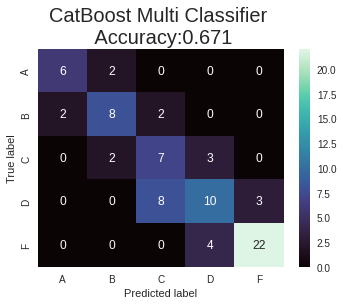

In [48]:
cm = confusion_matrix(test_target, preds)


cm_df = pd.DataFrame(cm,
                     index = ['A','B','C','D','F'],
                     columns = ['A','B','C','D','F'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap='mako')
plt.title('CatBoost Multi Classifier \n Accuracy:{0:.3f}'.format(accuracy_score(test_target, preds)), fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [49]:
pd.DataFrame(preds).value_counts()

F    25
D    17
C    17
B    12
A     8
dtype: int64

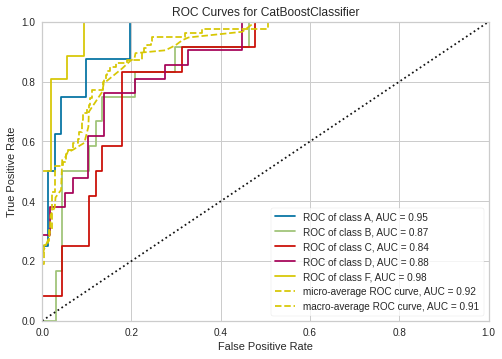

In [50]:
yellowbrick_model = wrap(best_model)
visualizer = ROCAUC(yellowbrick_model)
visualizer.fit(train_features, train_target)
visualizer.score(test_features, test_target)
visualizer.show()

## B) Modeling After the First Trimester (G1) for Letter Grade (A, B, C, D, F)

In [57]:
features = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
           'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
           'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
           'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
           'Walc', 'health', 'absences', 'G1']
target = ['Grade']

In [58]:
train_features = train_df[features]
train_target = train_df[target]

test_features = test_df[features]
test_target = test_df[target]

In [59]:
def objective(trial):

    params = {
        'iterations' : trial.suggest_int('iterations', 50, 300),
        'depth' : trial.suggest_int('depth', 2, 10),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    }

    # Conditional Hyper-Parameters
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)
    elif params["bootstrap_type"] == "MVS":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=my_seed)

    cv_scores = []

    for train_index, test_index in skf.split(train_features,train_target):

        train_x, valid_x = train_features.iloc[train_index], train_features.iloc[test_index]
        train_y, valid_y = train_target.iloc[train_index], train_target.iloc[test_index]  

        train_pool = cb.Pool(train_x, train_y, cat_features=categorical_features_indices)
        valid_pool = cb.Pool(valid_x, valid_y, cat_features=categorical_features_indices)

        classes = np.unique(train_y)
        weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_y.values.reshape(-1))
        class_weights = dict(zip(classes, weights))

        cb_multiclass_model = cb.CatBoostClassifier(**params, random_state=my_seed,
                                   loss_function='MultiClassOneVsAll', class_weights = class_weights)

        cb_multiclass_optuna = cb_multiclass_model.fit(train_pool, eval_set=valid_pool, verbose=False, 
                                         early_stopping_rounds=100, use_best_model=True)

        preds = cb_multiclass_optuna.predict(valid_x)

        F1 = f1_score(valid_y, preds, average='macro')

        cv_scores.append(F1)

    cv_avg_score = np.mean(cv_scores)    

    print('Avg F1 score of CV CatBoost Multi Classification=', cv_avg_score)

    return cv_avg_score

In [60]:
study = optuna.create_study(direction="maximize", sampler = TPESampler(seed=my_seed), study_name="Trimester 1 Multi Classification CV 5")
study.optimize(objective, n_trials=300, n_jobs=-1)

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.3809128914246853
Avg F1 score of CV CatBoost Multi Classification= 0.5139771442954212
Avg F1 score of CV CatBoost Multi Classification= 0.4634421193683516


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.42951760767546254
Avg F1 score of CV CatBoost Multi Classification= 0.4588130612535698
Avg F1 score of CV CatBoost Multi Classification= 0.46137422438359044
Avg F1 score of CV CatBoost Multi Classification= 0.33196021955378985
Avg F1 score of CV CatBoost Multi Classification= 0.42560927007385396
Avg F1 score of CV CatBoost Multi Classification= 0.4126062936384763
Avg F1 score of CV CatBoost Multi Classification= 0.3051377600249802
Avg F1 score of CV CatBoost Multi Classification= 0.670491698075869
Avg F1 score of CV CatBoost Multi Classification= 0.5552885122061564
Avg F1 score of CV CatBoost Multi Classification= 0.562722257916349
Avg F1 score of CV CatBoost Multi Classification= 0.559291103558429
Avg F1 score of CV CatBoost Multi Classification= 0.5530892797217358


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5885640335313227
Avg F1 score of CV CatBoost Multi Classification= 0.5861495665391397
Avg F1 score of CV CatBoost Multi Classification= 0.5310875665880243
Avg F1 score of CV CatBoost Multi Classification= 0.6380502847427343
Avg F1 score of CV CatBoost Multi Classification= 0.5809120850574632
Avg F1 score of CV CatBoost Multi Classification= 0.5605434363344987
Avg F1 score of CV CatBoost Multi Classification= 0.5433592628311485
Avg F1 score of CV CatBoost Multi Classification= 0.39746761176428974
Avg F1 score of CV CatBoost Multi Classification= 0.5941368553207702
Avg F1 score of CV CatBoost Multi Classification= 0.5871488361937656
Avg F1 score of CV CatBoost Multi Classification= 0.5707496807157466
Avg F1 score of CV CatBoost Multi Classification= 0.5820819103130874
Avg F1 score of CV CatBoost Multi Classification= 0.5597747054566268
Avg F1 score of CV CatBoost Multi Classification= 0.49368454726623323
Avg F1 score of CV CatBoost Mult

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5056442428691634
Avg F1 score of CV CatBoost Multi Classification= 0.40604399039112815


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5169257807144237
Avg F1 score of CV CatBoost Multi Classification= 0.4002602720656382
Avg F1 score of CV CatBoost Multi Classification= 0.562818673594052
Avg F1 score of CV CatBoost Multi Classification= 0.571830690726841
Avg F1 score of CV CatBoost Multi Classification= 0.544562490687568
Avg F1 score of CV CatBoost Multi Classification= 0.5232396439055478
Avg F1 score of CV CatBoost Multi Classification= 0.527424305118285
Avg F1 score of CV CatBoost Multi Classification= 0.36457022490459023
Avg F1 score of CV CatBoost Multi Classification= 0.5284553190868871
Avg F1 score of CV CatBoost Multi Classification= 0.512292833268847
Avg F1 score of CV CatBoost Multi Classification= 0.4586395933175803
Avg F1 score of CV CatBoost Multi Classification= 0.5486246367777252
Avg F1 score of CV CatBoost Multi Classification= 0.5691543092283153
Avg F1 score of CV CatBoost Multi Classification= 0.5917788598165912
Avg F1 score of CV CatBoost Multi Clas

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5198707653732246
Avg F1 score of CV CatBoost Multi Classification= 0.5837372241561495
Avg F1 score of CV CatBoost Multi Classification= 0.5890768750144844
Avg F1 score of CV CatBoost Multi Classification= 0.6107855192622994
Avg F1 score of CV CatBoost Multi Classification= 0.5676570430810571
Avg F1 score of CV CatBoost Multi Classification= 0.554773379720781
Avg F1 score of CV CatBoost Multi Classification= 0.5568848625991729
Avg F1 score of CV CatBoost Multi Classification= 0.5272949527604952
Avg F1 score of CV CatBoost Multi Classification= 0.5727913059672964
Avg F1 score of CV CatBoost Multi Classification= 0.5662699843158064
Avg F1 score of CV CatBoost Multi Classification= 0.5332992845088773
Avg F1 score of CV CatBoost Multi Classification= 0.5481581543685331
Avg F1 score of CV CatBoost Multi Classification= 0.5686587057629398
Avg F1 score of CV CatBoost Multi Classification= 0.576114068787508
Avg F1 score of CV CatBoost Multi Cl

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5863657365362455
Avg F1 score of CV CatBoost Multi Classification= 0.6042489942664255
Avg F1 score of CV CatBoost Multi Classification= 0.607015397898996
Avg F1 score of CV CatBoost Multi Classification= 0.5085395843369155
Avg F1 score of CV CatBoost Multi Classification= 0.565965024088863
Avg F1 score of CV CatBoost Multi Classification= 0.5692928168724715
Avg F1 score of CV CatBoost Multi Classification= 0.542104842932655
Avg F1 score of CV CatBoost Multi Classification= 0.5529544654893283
Avg F1 score of CV CatBoost Multi Classification= 0.5383220794100115
Avg F1 score of CV CatBoost Multi Classification= 0.5428724055058689
Avg F1 score of CV CatBoost Multi Classification= 0.5746041521103533
Avg F1 score of CV CatBoost Multi Classification= 0.37206037907310785
Avg F1 score of CV CatBoost Multi Classification= 0.5950756178143761
Avg F1 score of CV CatBoost Multi Classification= 0.5846962020952517
Avg F1 score of CV CatBoost Multi Cl

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5616698155158109
Avg F1 score of CV CatBoost Multi Classification= 0.5814389687013068
Avg F1 score of CV CatBoost Multi Classification= 0.5560578828156216
Avg F1 score of CV CatBoost Multi Classification= 0.5790453046949399


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5175751045284209
Avg F1 score of CV CatBoost Multi Classification= 0.6071616572593059
Avg F1 score of CV CatBoost Multi Classification= 0.5774950922658209
Avg F1 score of CV CatBoost Multi Classification= 0.5704979515906081
Avg F1 score of CV CatBoost Multi Classification= 0.56708546936828
Avg F1 score of CV CatBoost Multi Classification= 0.5764896475909941
Avg F1 score of CV CatBoost Multi Classification= 0.4159987212546983
Avg F1 score of CV CatBoost Multi Classification= 0.595032721687651
Avg F1 score of CV CatBoost Multi Classification= 0.5778481569915324
Avg F1 score of CV CatBoost Multi Classification= 0.5900670819337586
Avg F1 score of CV CatBoost Multi Classification= 0.5984290972851906
Avg F1 score of CV CatBoost Multi Classification= 0.5809346774134918
Avg F1 score of CV CatBoost Multi Classification= 0.5771861237451829
Avg F1 score of CV CatBoost Multi Classification= 0.5687963903415563
Avg F1 score of CV CatBoost Multi Cla

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6171400265936502
Avg F1 score of CV CatBoost Multi Classification= 0.498689642645019
Avg F1 score of CV CatBoost Multi Classification= 0.5861229484501668
Avg F1 score of CV CatBoost Multi Classification= 0.5745318484351143
Avg F1 score of CV CatBoost Multi Classification= 0.550705981558907
Avg F1 score of CV CatBoost Multi Classification= 0.5568075685797549
Avg F1 score of CV CatBoost Multi Classification= 0.5819424588422188
Avg F1 score of CV CatBoost Multi Classification= 0.5784525247331258
Avg F1 score of CV CatBoost Multi Classification= 0.5702098442930128
Avg F1 score of CV CatBoost Multi Classification= 0.6246290455407231
Avg F1 score of CV CatBoost Multi Classification= 0.5105023315184802
Avg F1 score of CV CatBoost Multi Classification= 0.5566787061266385
Avg F1 score of CV CatBoost Multi Classification= 0.5615072928828778
Avg F1 score of CV CatBoost Multi Classification= 0.5583656607648303
Avg F1 score of CV CatBoost Multi Cl

In [61]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 300
Best trial:
  Value: 0.6297837080269024
  Params: 
    iterations: 159
    depth: 8
    learning_rate: 0.2496047798816307
    random_strength: 22
    od_type: IncToDec
    colsample_bylevel: 0.09649110427494943
    boosting_type: Ordered
    bootstrap_type: MVS
    subsample: 0.8020430567284894


In [62]:
optuna.visualization.plot_optimization_history(study)

In [63]:
classes = np.unique(train_target)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_target.values.reshape(-1))
class_weights = dict(zip(classes, weights))

best_model = cb.CatBoostClassifier(loss_function='MultiClassOneVsAll', class_weights = class_weights)
best_model = best_model.set_params(**study.best_params)
best_model = best_model.fit(train_features, train_target, cat_features= categorical_features_indices, verbose=False, early_stopping_rounds=100)

preds = best_model.predict(test_features)

f1score = f1_score(test_target, preds, average='macro')

print('F1 Score of CatBoost =', f1score)

F1 Score of CatBoost = 0.497419254173818


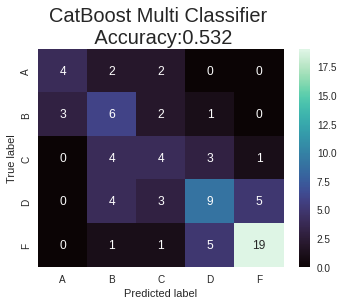

In [64]:
cm = confusion_matrix(test_target, preds)


cm_df = pd.DataFrame(cm,
                     index = ['A','B','C','D','F'],
                     columns = ['A','B','C','D','F'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap='mako')
plt.title('CatBoost Multi Classifier \n Accuracy:{0:.3f}'.format(accuracy_score(test_target, preds)), fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [65]:
pd.DataFrame(preds).value_counts()

F    25
D    18
B    17
C    12
A     7
dtype: int64

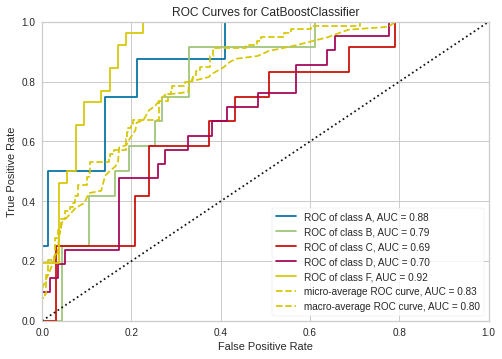

In [66]:
yellowbrick_model = wrap(best_model)
visualizer = ROCAUC(yellowbrick_model)
visualizer.fit(train_features, train_target)
visualizer.score(test_features, test_target)
visualizer.show()